In [118]:
#bayesian import
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [119]:
#challenge import
from netsapi.challenge import *
 
from sys import exit, exc_info, argv
from multiprocessing import Pool, current_process
import random as rand
import json
import requests
import numpy as np
import pandas as pd


import statistics
from IPython.display import clear_output

from contextlib import contextmanager
import sys, os
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
print("done")

done


# Target Function

Lets create a target 1-D function with multiple local maxima to test and visualize how the [BayesianOptimization](https://github.com/fmfn/BayesianOptimization) package works. The target function we will try to maximize is the following:

$$f(x) = e^{-(x - 2)^2} + e^{-\frac{(x - 6)^2}{10}} + \frac{1}{x^2 + 1}, $$ its maximum is at $x = 2$ and we will restrict the interval of interest to $x \in (-2, 10)$.

Notice that, in practice, this function is unknown, the only information we have is obtained by sequentialy probing it at different points. Bayesian Optimization works by contructing a posterior distribution of functions that best fit the data observed and chosing the next probing point by balancing exploration and exploitation.

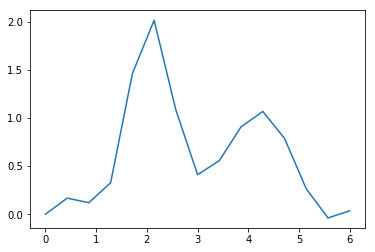

In [120]:

x_start= 0.0
x_end = 6.0



def target(x):
    return target1(x,x_end-x)
        
def target1(x,y):  
    a = np.exp(-( (x - 2)**2/0.7 + (y - 4)**2/1.2) + (x - 2)*(y - 4)/1.6 )
    b = np.exp(-( (x - 4)**2/3 + (y - 2)**2/2.) )
    c = np.exp(-( (x - 4)**2/0.5 + (y - 4)**2/0.5) + (x - 4)*(y - 4)/0.5 )
    d = np.sin(3.1415 * x)
    e = np.exp(-( (x - 5.5)**2/0.5 + (y - 5.5)**2/.5) )
    return 2*a + b - c + 0.17 * d + 2*e


x = np.linspace(x_start, x_end, 15).reshape(-1, 1)
y = target(x)
plt.plot(x, y);



# Create a BayesianOptimization Object

Enter the target function to be maximized, its variable(s) and their corresponding ranges. A minimum number of 2 initial guesses is necessary to kick start the algorithms, these can either be random or user defined.

In [121]:
optimizer = BayesianOptimization(target, {'x': (0, 6)}) # BayesianOptimization(target, {'x': (x_start, x_end)}, random_state=27)

In this example we will use the Upper Confidence Bound (UCB) as our utility function. It has the free parameter
$\kappa$ which control the balance between exploration and exploitation; we will set $\kappa=5$ which, in this case, makes the algorithm quite bold.

In [122]:
optimizer.maximize(init_points=2, n_iter=0, kappa=5)

|   iter    |  target   |     x     |
-------------------------------------
|  1        |  0.125    |  0.8313   |
|  2        |  1.061    |  4.159    |


# Plotting and visualizing the algorithm at each step

### Let's first define a couple functions to make plotting easier

In [123]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((x_start, x_end))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((x_start, x_end))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

### Two random points

After we probe two points at random, we can fit a Gaussian Process and start the bayesian optimization procedure. Two points should give us a uneventful posterior with the uncertainty growing as we go further from the observations.

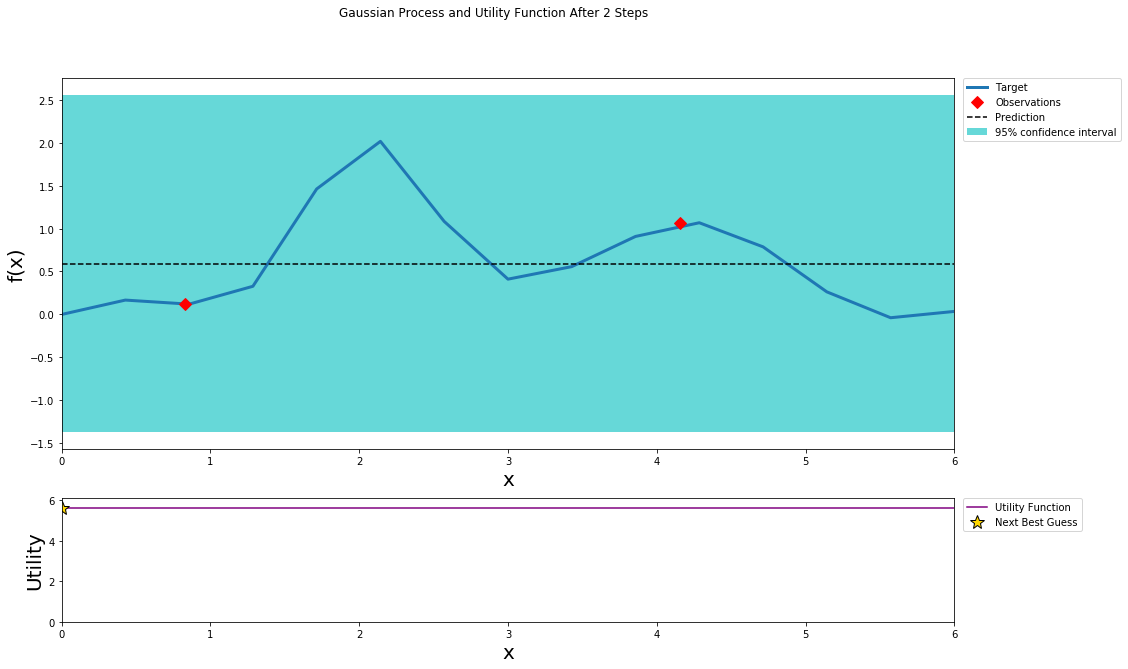

In [124]:
plot_gp(optimizer, x, y)

### After one step of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  3        |  1.061    |  4.159    |


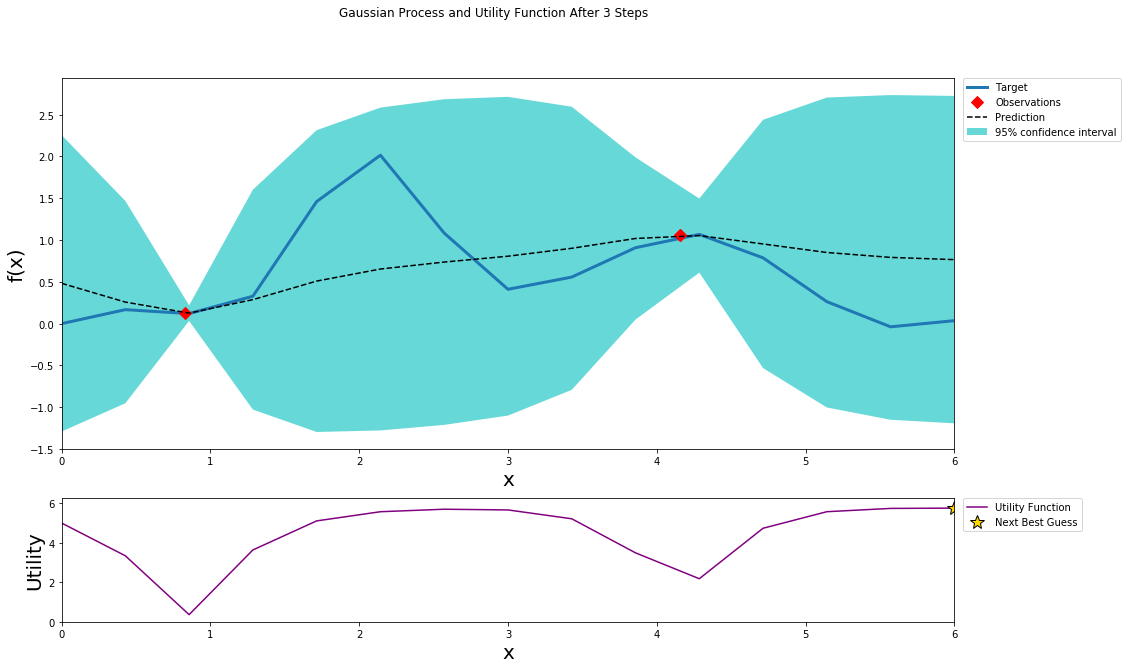

In [125]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)

### After two steps of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  4        |  0.008514 |  5.932    |


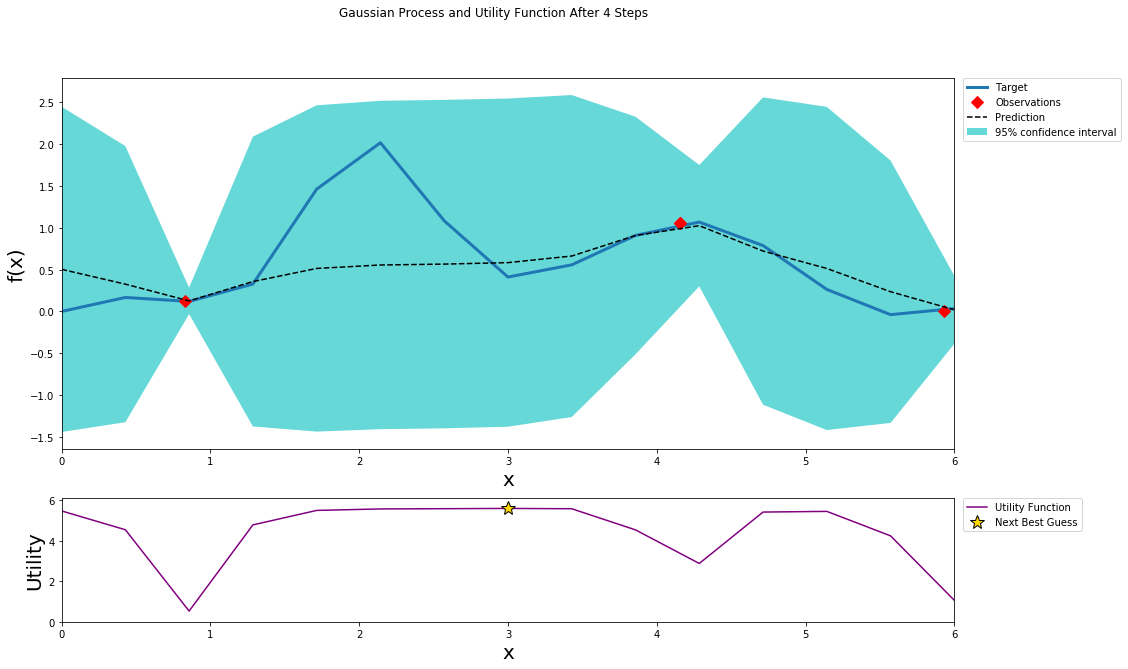

In [126]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)

### After three steps of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  5        |  0.4275   |  3.236    |


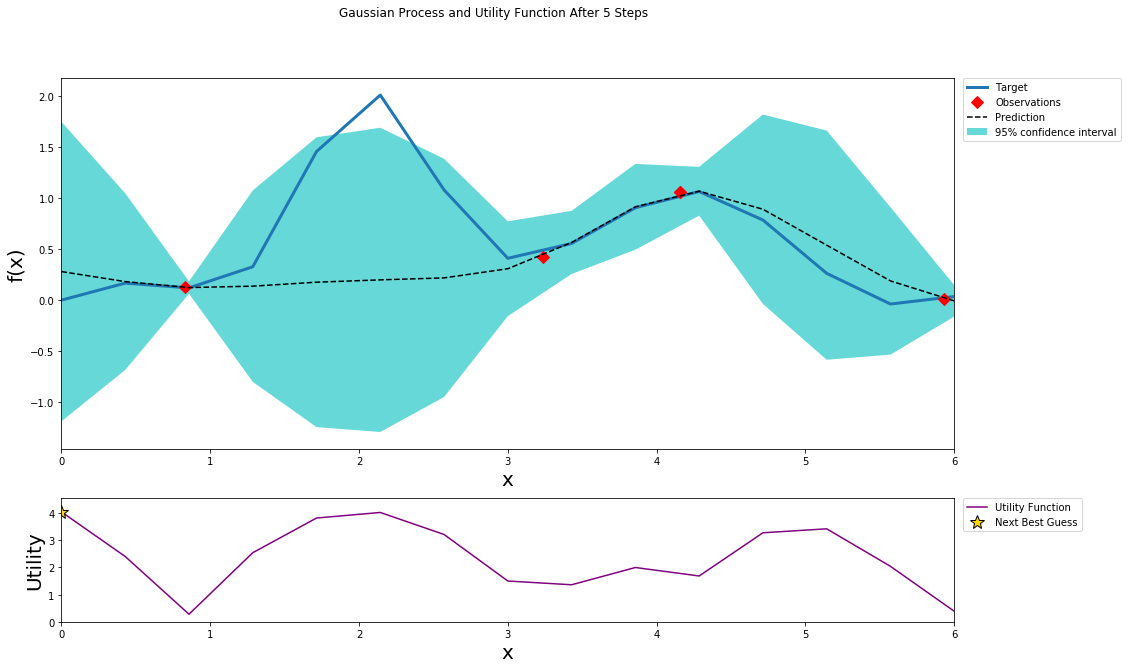

In [127]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)

### After four steps of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  6        |  2.043    |  2.013    |


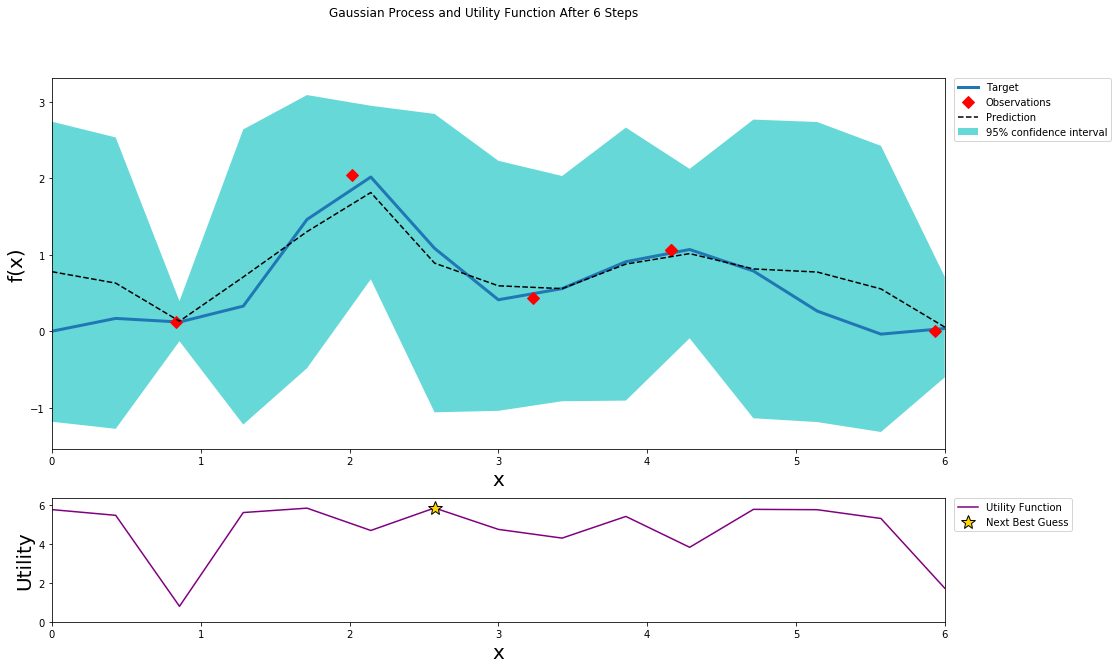

In [128]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)

### After five steps of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  7        |  1.503    |  2.409    |


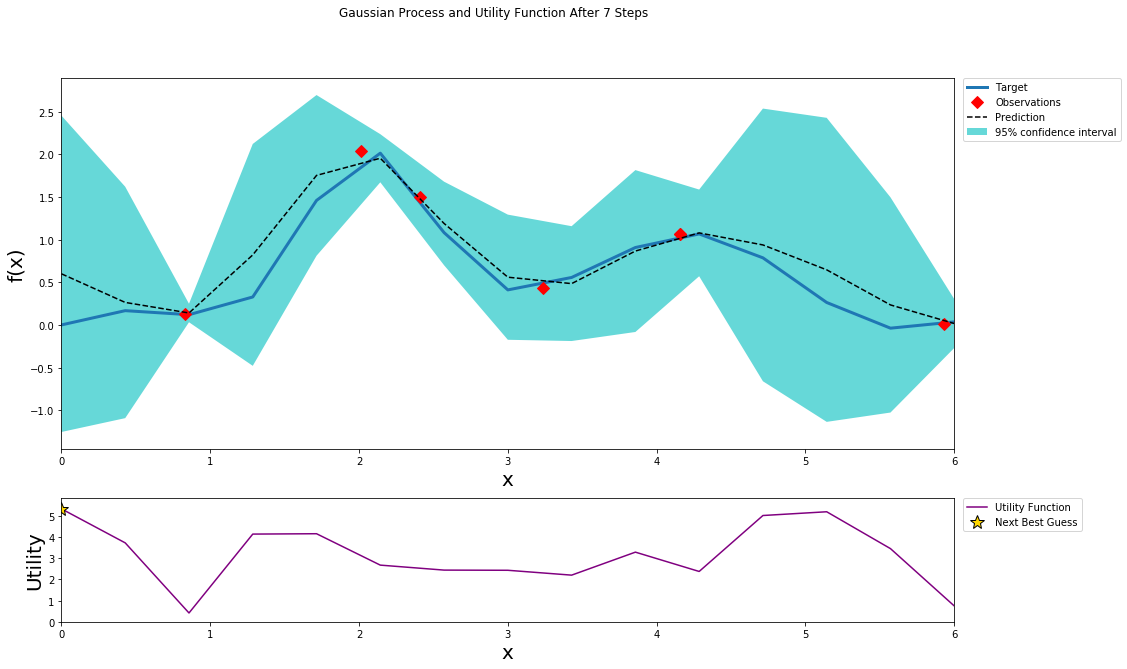

In [129]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)

### After six steps of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  8        |  0.479    |  4.965    |


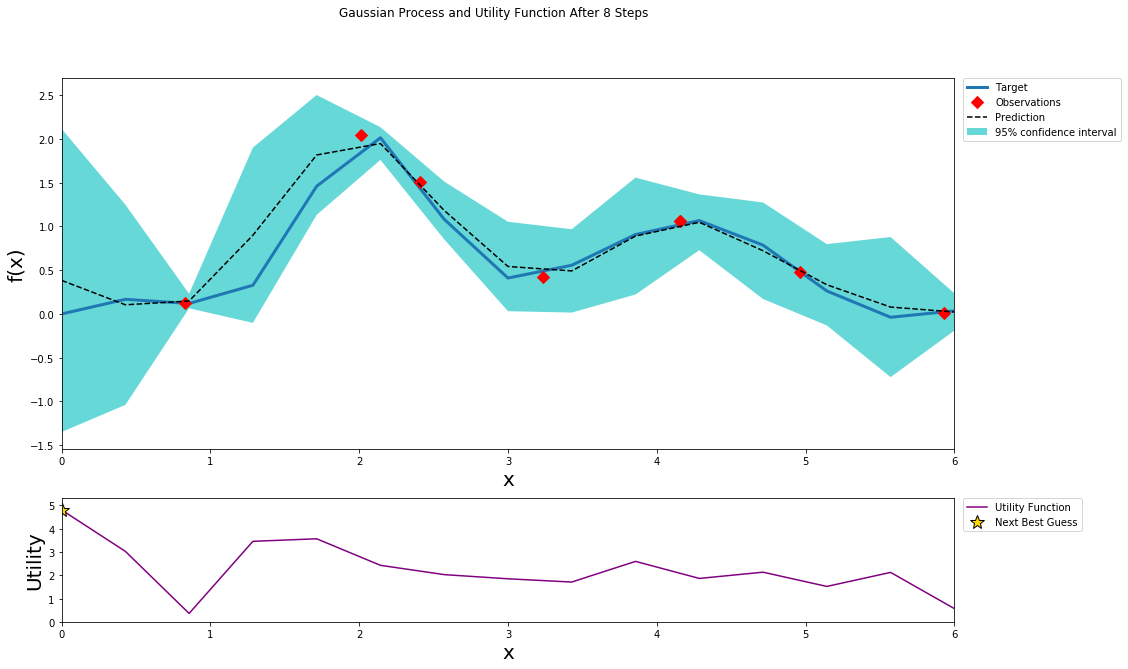

In [130]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)

### After seven steps of GP (and two random points)

|   iter    |  target   |     x     |
-------------------------------------
|  9        |  2.094e-0 |  0.0      |


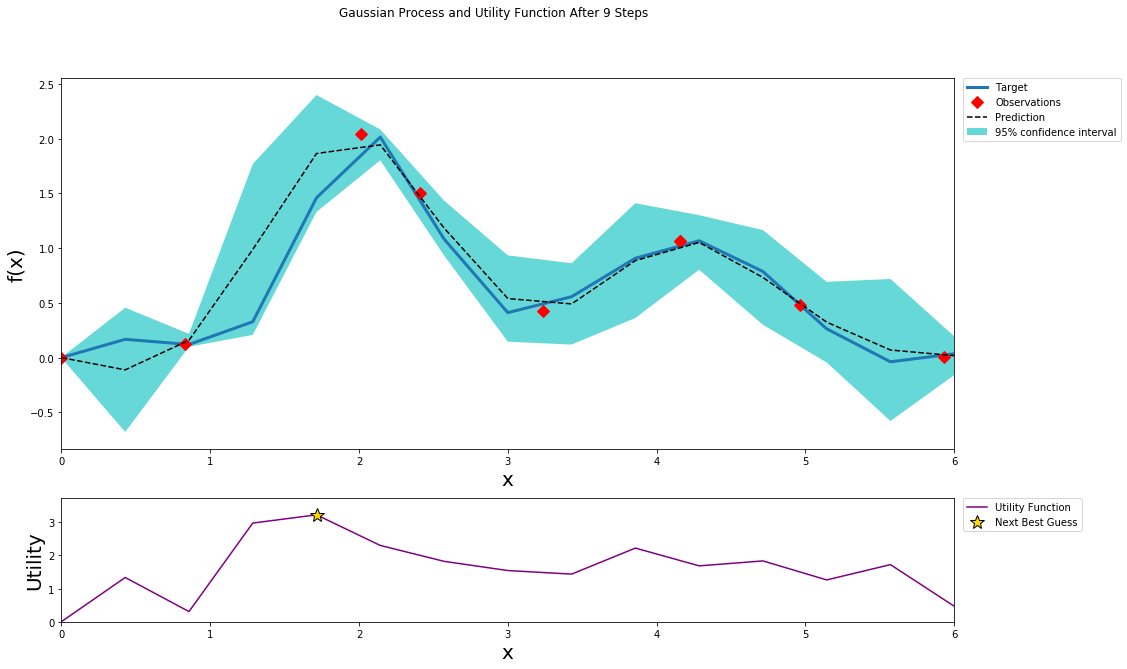

In [131]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)

# Stopping

After just a few points the algorithm was able to get pretty close to the true maximum. It is important to notice that the trade off between exploration (exploring the parameter space) and exploitation (probing points near the current known maximum) is fundamental to a succesful bayesian optimization procedure. The utility function being used here (Upper Confidence Bound - UCB) has a free parameter $\kappa$ that allows the user to make the algorithm more or less conservative. Additionally, a the larger the initial set of random points explored, the less likely the algorithm is to get stuck in local minima due to being too conservative.

|   iter    |  target   |     x     |
-------------------------------------
|  10       |  0.906    |  1.534    |
|  11       |  0.8156   |  3.739    |
|  12       |  1.99     |  2.166    |
|  13       |  2.052    |  2.076    |
|  14       |  2.054    |  2.052    |


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.2258462e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


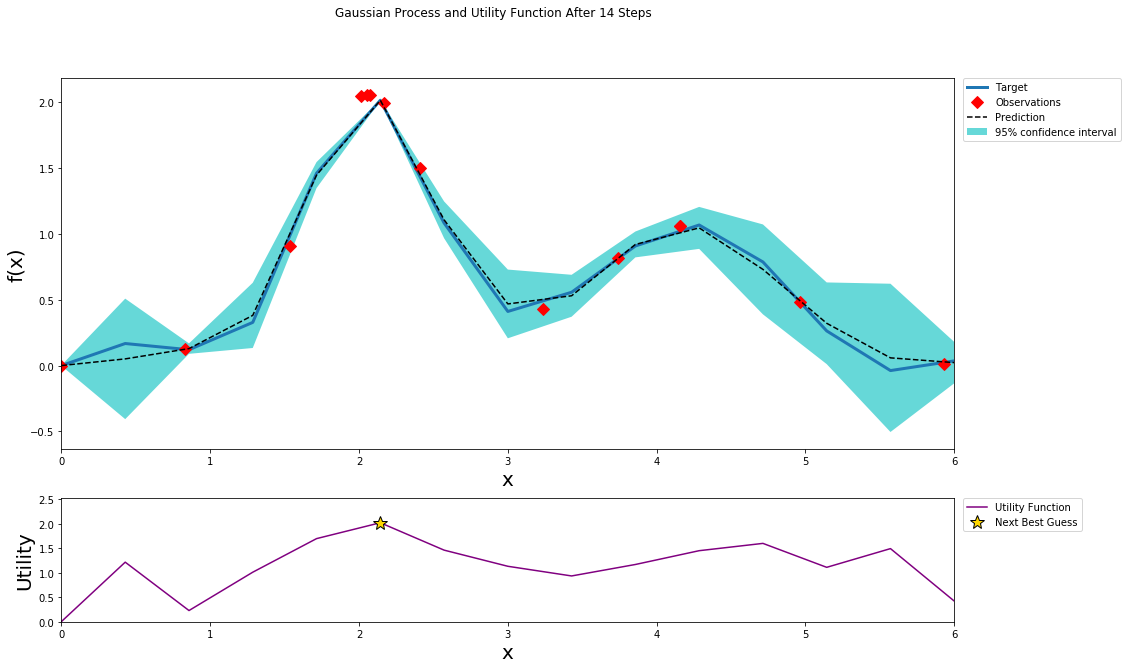

In [132]:
optimizer.maximize(init_points=0, n_iter=5, kappa=5)
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
|  15       |  2.054    |  2.055    |
|  16       |  2.054    |  2.056    |
|  17       |  2.054    |  2.057    |
|  18       |  2.054    |  2.057    |
|  19       |  2.054    |  2.065    |


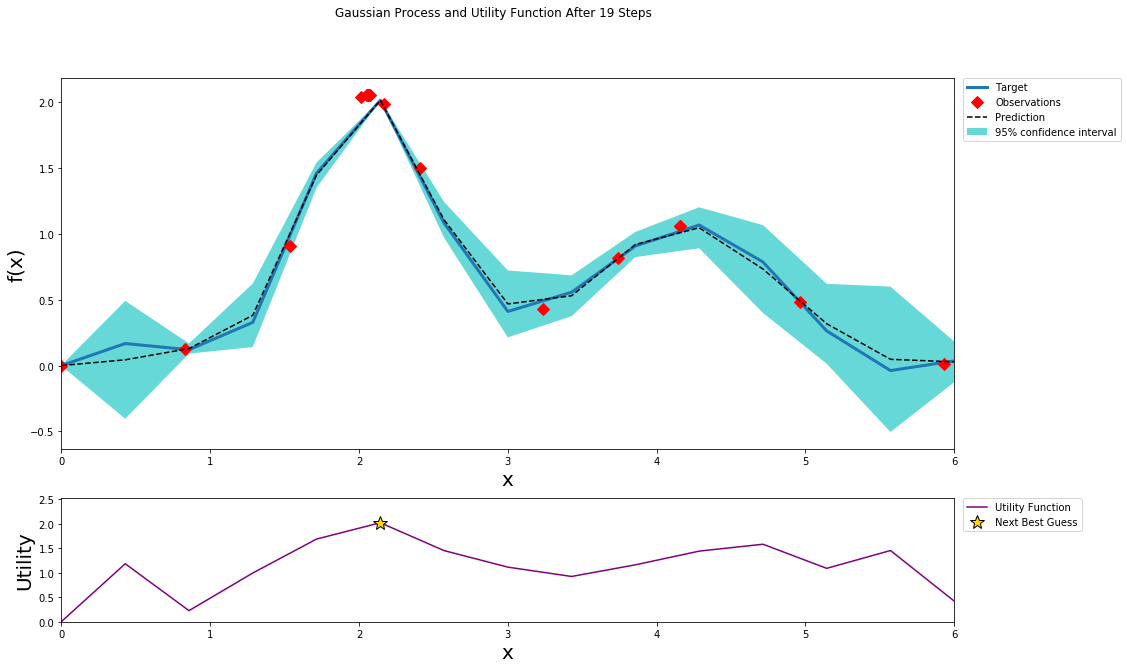

In [133]:
optimizer.maximize(init_points=0, n_iter=5, kappa=5)
plot_gp(optimizer, x, y)